In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("C://Users/sz/Desktop/practice/take_home_challenges/")
import helper_f
%matplotlib inline

# Objectives

- Figure out percentage of users who opened email and what percentage clicked on link
- Optimize future email campaign by locating better group of users who are likely to click on link
- click through rate improvement by the model? how to test it
- interesting patterns

read three tables

### Objective 1, we find that 1.071% users opened link, and 0.208% users clicked the link

In [2]:
email = pd.read_csv("email_table.csv")
opened = pd.read_csv("email_opened_table.csv")
clicked = pd.read_csv("link_clicked_table.csv")

In [3]:
#create two columns 'opened' and 'clicked' in email table
email['opened'] = email['email_id'].apply(lambda idx: 1 if idx in opened.index else 0)
email['clicked'] = email['email_id'].apply(lambda idx: 1 if idx in clicked.index else 0)

In [4]:
print("Pertange of people who opened: {}".format(np.mean(email['opened'])))
print("Pertange of people who clicked {}".format(np.mean(email['clicked'])))

Pertange of people who opened: 0.01071
Pertange of people who clicked 0.00208


In [5]:
#make sure there is no 'clicked but not opened error'
print("Number of people who clicked but not opened: {}".format(np.sum(email['clicked'] > email['opened'])))

Number of people who clicked but not opened: 0


## Objective 2

After analysis on almost every feature, I find that *email_text* has almost zero effect, but *version*, *hour*, *weekday*, *country* are meaningful features and marketing team can do a lot with these findings. Lastly, *past purchase* actually has no positive relationship with *click*/*open*. 

## Model

1. change *email version* to generic
2. send emails later everyday
3. More emails on *Monday, Saturday, Thursday*
4. More emails to *UK, ES* users

In [6]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,0,0
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


clicked
0    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
1    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

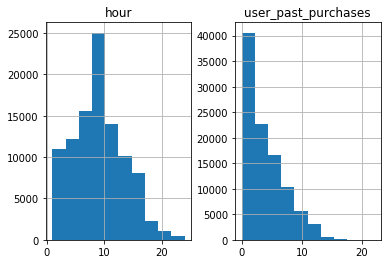

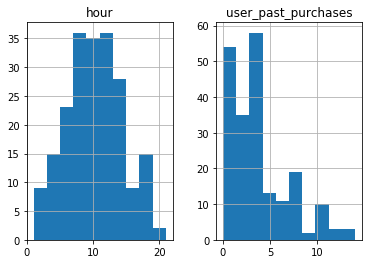

In [7]:
#look at a quick distribution of hour and past purchase for two groups
email.groupby(['clicked']).hist(column = ['hour','user_past_purchases'])

In [8]:
#actually it is not a good idea to plot feature relationship when most features are categorical. But anyway, scatterplot it
#and see if there is any findings 

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder

clean_table = email.drop(['email_id','opened'], axis = 1)
le = LabelEncoder()
for col in ['email_text','email_version']:
    clean_table[col] = le.fit_transform(clean_table[col])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021875212A90>,
      dtype=object)

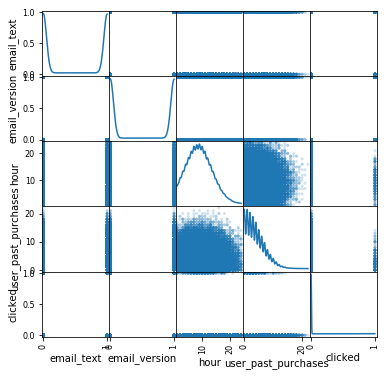

In [9]:
#not surprisingly, no find here
scatter_matrix(clean_table, alpha = 0.2, figsize = (6,6), diagonal = 'kde')

- Analyze the effect of **email_text**

We see that there is only a slight difference in terms of *open rate* and *click through rate* between long and short groups

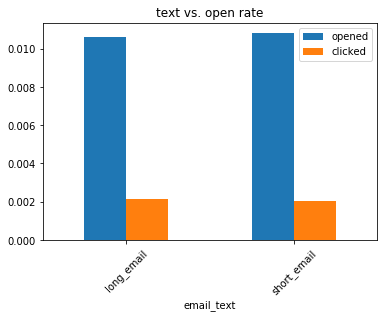

In [10]:
email_text = email.groupby(['email_text'])['opened', 'clicked'].mean()
email_text.plot(kind='bar', title= 'text vs. open rate', rot = 45)

- Analyze the effect of **email_version**

Very surprisingly, the generic email user group actually has a higher open/click rate than personalized email group. Therefore, in the future, one improvement that the marketing team could do is to send less personalized emails and more generic ones 

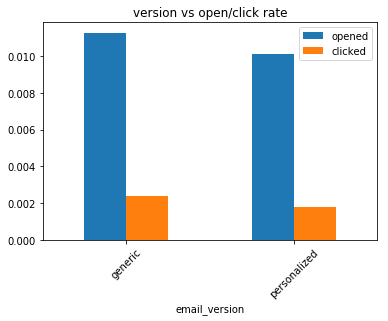

In [11]:
email_version = email.groupby(['email_version'])['opened', 'clicked'].mean()
email_version.plot(kind = 'bar',title= 'version vs open/click rate', rot = 45)

- Analyze the effect of **weekday**


1. Very interestingly, open rate and click through rate does not have the same trend
2. For click through rate, Saturday is the highest, while Friday is the lowest. On Saturaday, users have more free time and are more likely to click on links, while on Friday people are more likely to hang out and have no time clicking any links
3. For both open/click through rate, Midweek and Sunday are lowest, showing that people are either too busy working or enjoying free time

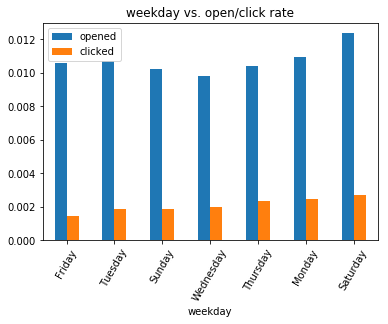

In [12]:
weekday = email.groupby(['weekday'])['opened','clicked'].mean().sort_values(by = 'clicked')
weekday.plot(kind = 'bar', title = 'weekday vs. open/click rate', rot = 60)

- Analyze the effect of **country**

Country does matter to click through rate! Users in UK are more likely to open the email and click the link; while users in US are less likely to do that. So in the future, marketing team could send more emails to UK users

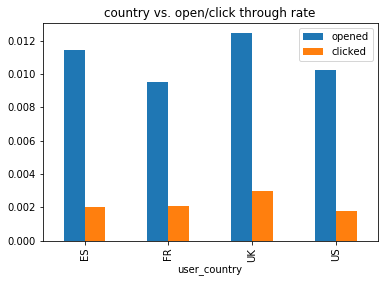

In [13]:
country = email.groupby(['user_country'])['opened', 'clicked'].mean()
country.plot(kind = 'bar', title = 'country vs. open/click through rate')

- Analyze the effect of **past purchases**

Very surprisingly, actually those who do not open email/click link has more past purchases than those who do open/click

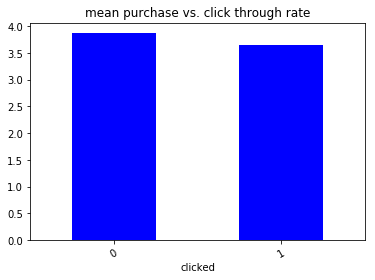

In [14]:
past_purchase = email.groupby('clicked')['user_past_purchases'].mean()
past_purchase.plot(kind = 'bar', title = 'mean purchase vs. click through rate', rot = 30, color = 'b')

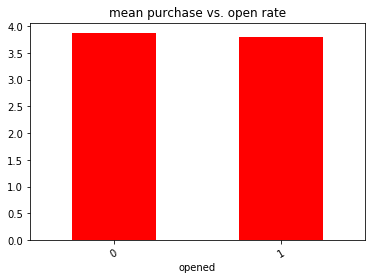

In [15]:
past_purchase_open = email.groupby('opened')['user_past_purchases'].mean()
past_purchase_open.plot(kind = 'bar', title = 'mean purchase vs. open rate', rot = 30, color ='r')

- Analyze the effect of **hour**

Interestingly, the mean hour of users who click is slightly later than that of users who do not click. So another thing for marketing team to do is to send emails a little later in the future

clicked
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hour, dtype: object

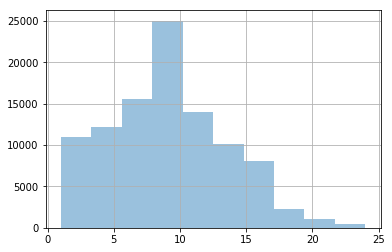

In [16]:
#we see two groups overlap on hour
email.groupby('clicked')['hour'].hist(alpha = 0.45)

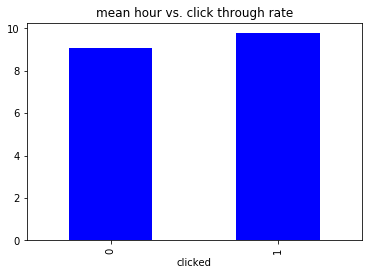

In [17]:
email.groupby('clicked')['hour'].mean().plot(kind = 'bar', color = 'b', title = 'mean hour vs. click through rate')

## Objective 3. Test my model with A/B test

I would test click through rate using A/B test. Extract users in my model and other users, and calculate t-statistics and p-value.<br>

1. Because p-value = 0.0518 > 0.05, we reject null hypothesis and there is no statistical significance between click through rate of my model and whole group of users.
2. But lets A/B test my model with exclusion my model user group from whole group. This time, p-value = 0.0348 < 0.05, showing that there is a statistical significance between my model and old ones

In [18]:
#extract my targetting group
my_model = email.loc[(email['email_version'] == 'generic') & (email['user_country'].isin(['UK','ES'])) & \
                        (email['weekday'].isin(['Saturday', 'Monday','Thursday']))]

In [19]:
import scipy
t, p = scipy.stats.ttest_ind(my_model['clicked'], email['clicked'])
print("p value is: {}".format(p))

p value is: 0.05177588966560498


In [20]:
exclusion = email[email['email_id'].isin(my_model['email_id']) == False]
newt,newp = scipy.stats.ttest_ind(my_model['clicked'], exclusion['clicked'])
print("p value is: {}".format(newp))

p value is: 0.03482190548081924
